# Image Super-Resolution with ESPCN
For a full explanation of the concepts included in this notebook, check out [Image Super-Resolution: A Comprehensive Review](https://blog.paperspace.com/image-super-resolution/) on the blog. 

We will be using the DIV2K dataset to train the model. We split the 2k resolution images into patches of 17×17 to provide as model input for training. 

In [1]:
!wget data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
!unzip DIV2K_train_HR.zip -d ./Training
!rm DIV2K_train_HR.zip

--2021-07-19 16:01:42--  http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip [following]
--2021-07-19 16:01:43--  https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3530603713 (3.3G) [application/zip]
Saving to: ‘DIV2K_train_HR.zip’

DIV2K_train_HR.zip  100%[===================>]   3.29G  31.1MB/s    in 1m 50s  

2021-07-19 16:03:33 (30.5 MB/s) - ‘DIV2K_train_HR.zip’ saved [3530603713/3530603713]

Archive:  DIV2K_train_HR.zip
   creating: ./Training/DIV2K_train_HR/
  inflating: ./Training/DIV2K_train_HR/0103.png

In [2]:
!apt update && apt install -y libsm6 libxext6 libxrender-dev
!apt install -y libgl1-mesa-glx
!pip install opencv-python

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:11 http://security.ubuntu.com/ubuntu bionic-security/universe amd64 Packages [1,418 kB]
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 

In [3]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras import backend as K

In [4]:
upscale_factor = 3

inputs = keras.Input(shape=(None, None, 1))
conv1 = layers.Conv2D(64, 5, activation="tanh", padding="same")(inputs)
conv2 = layers.Conv2D(32, 3, activation="tanh", padding="same")(conv1)
conv3 = layers.Conv2D((upscale_factor*upscale_factor), 3, activation="sigmoid", padding="same")(conv2)
outputs = tf.nn.depth_to_space(conv3, upscale_factor, data_format='NHWC')
model = Model(inputs=inputs, outputs=outputs)

In [5]:
def gen_dataset(filenames, scale):
    # The model trains on 17x17 patches
    crop_size_lr = 17
    crop_size_hr = 17 * scale

    for p in filenames:
        image_decoded = cv2.imread("Training/DIV2K_train_HR/"+p.decode(), 3).astype(np.float32) / 255.0
        imgYCC = cv2.cvtColor(image_decoded, cv2.COLOR_BGR2YCrCb)
        cropped = imgYCC[0:(imgYCC.shape[0] - (imgYCC.shape[0] % scale)),
                  0:(imgYCC.shape[1] - (imgYCC.shape[1] % scale)), :]
        lr = cv2.resize(cropped, (int(cropped.shape[1] / scale), int(cropped.shape[0] / scale)),
                        interpolation=cv2.INTER_CUBIC)

        hr_y = imgYCC[:, :, 0]
        lr_y = lr[:, :, 0]

        numx = int(lr.shape[0] / crop_size_lr)
        numy = int(lr.shape[1] / crop_size_lr)
        for i in range(0, numx):
            startx = i * crop_size_lr
            endx = (i * crop_size_lr) + crop_size_lr
            startx_hr = i * crop_size_hr
            endx_hr = (i * crop_size_hr) + crop_size_hr
            for j in range(0, numy):
                starty = j * crop_size_lr
                endy = (j * crop_size_lr) + crop_size_lr
                starty_hr = j * crop_size_hr
                endy_hr = (j * crop_size_hr) + crop_size_hr

                crop_lr = lr_y[startx:endx, starty:endy]
                crop_hr = hr_y[startx_hr:endx_hr, starty_hr:endy_hr]

                hr = crop_hr.reshape((crop_size_hr, crop_size_hr, 1))
                lr = crop_lr.reshape((crop_size_lr, crop_size_lr, 1))
                yield lr, hr

In [6]:
import os

filenames = os.listdir("Training/DIV2K_train_HR/")
ds = tf.data.Dataset.from_generator(
        gen_dataset, (tf.float32, tf.float32), (tf.TensorShape([None, None, 1]), tf.TensorShape([None, None, 1])),
        args=[filenames, upscale_factor]).batch(64).shuffle(buffer_size=10000)

def PSNR(y_true, y_pred):
    max_pixel = 1.0
    return tf.image.psnr(y_true, y_pred, max_val=max_pixel)

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt,
              loss='mse', 
              metrics=[PSNR])

In [7]:
model.fit(ds, epochs=5, verbose=2)

Epoch 1/5
13141/13141 - 311s - loss: 0.0044 - PSNR: 26.8803
Epoch 2/5
13141/13141 - 292s - loss: 0.0039 - PSNR: 27.3159
Epoch 3/5
13141/13141 - 294s - loss: 0.0037 - PSNR: 27.8986
Epoch 4/5
13141/13141 - 293s - loss: 0.0032 - PSNR: 29.2556
Epoch 5/5
13141/13141 - 293s - loss: 0.0032 - PSNR: 29.4858


Peak Signal to Noise Ratio is the most common technique used to determine the quality of results.

In [8]:
import math

def PSNR(orig, reconstr):
    mse = np.mean((orig.astype(float) - reconstr.astype(float)) ** 2)
    if mse != 0:
        max_pixel = 255.0
        return 20 * math.log10(max_pixel / math.sqrt(mse))
    else:
        return 1


The authors convert RGB images to the YCrCb format, and then upscale the Y channel input using ESPCN. The Cr and Cb channels are upscaled using bicubic interpolation, and all the upscaled channels are stitched together to get the final HR image. Thus, while training, we only need to provide the Y channel of the low resolution data and the high resolution images to the model.

In [9]:
# Download a sample image
!wget https://s3.amazonaws.com/ps.public.resources/ml-showcase/messi.jpg

--2021-07-19 16:30:23--  https://s3.amazonaws.com/ps.public.resources/ml-showcase/messi.jpg
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.11.38
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.11.38|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 325059 (317K) [image/jpeg]
Saving to: ‘messi.jpg’

messi.jpg           100%[===================>] 317.44K  --.-KB/s    in 0.01s   

2021-07-19 16:30:23 (25.9 MB/s) - ‘messi.jpg’ saved [325059/325059]



In [10]:
fullimg = cv2.imread("messi.jpg", 3)
width = fullimg.shape[0]
height = fullimg.shape[1]
cropped = fullimg[0:(width - (width % upscale_factor)), 0:(height - (height % upscale_factor)), :]
img = cv2.resize(cropped, None, fx=1. / upscale_factor, fy=1. / upscale_factor, interpolation=cv2.INTER_CUBIC)
floatimg = img.astype(np.float32) / 255.0
imgYCbCr = cv2.cvtColor(floatimg, cv2.COLOR_BGR2YCrCb)
imgY = imgYCbCr[:, :, 0]
LR_input_ = imgY.reshape(1, imgY.shape[0], imgY.shape[1], 1)
Y = model.predict([LR_input_])[0]
Cr = np.expand_dims(cv2.resize(imgYCbCr[:, :, 1], None, fx=upscale_factor, fy=upscale_factor, interpolation=cv2.INTER_CUBIC),
                    axis=2)
Cb = np.expand_dims(cv2.resize(imgYCbCr[:, :, 2], None, fx=upscale_factor, fy=upscale_factor, interpolation=cv2.INTER_CUBIC),
                    axis=2)
HR_image_YCrCb = np.concatenate((Y, Cr, Cb), axis=2)
HR_image = ((cv2.cvtColor(HR_image_YCrCb, cv2.COLOR_YCrCb2BGR)) * 255.0).clip(min=0, max=255)
HR_image = (HR_image).astype(np.uint8)
bicubic_image = cv2.resize(img, None, fx=upscale_factor, fy=upscale_factor, interpolation=cv2.INTER_CUBIC)

print("PSNR of ESPCN generated image: ", PSNR(cropped, HR_image))
print("PSNR of bicubic interpolated image: ", PSNR(cropped, bicubic_image))

PSNR of ESPCN generated image:  27.0881099976027
PSNR of bicubic interpolated image:  27.474722648157446


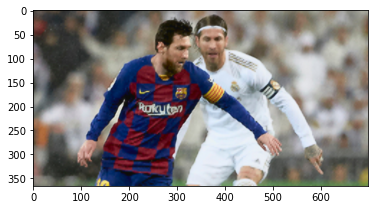

In [11]:
from matplotlib import pyplot as plt
plt.imshow(cv2.cvtColor(HR_image, cv2.COLOR_BGR2RGB))

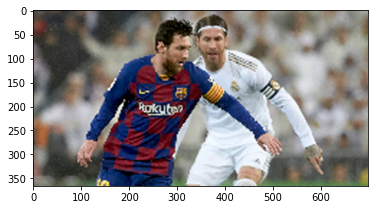

In [12]:
plt.imshow(cv2.cvtColor(bicubic_image, cv2.COLOR_BGR2RGB))